In [96]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import display as show_this
import ipywidgets as widgets

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

from hparams import create_hparams
from model import Tacotron2, load_model
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml
from mcd_wrapper import _calculate_mcd
from interpolate_rhythm import Cubic_Solver
from train_step import Train_Step

In [2]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

In [3]:
def line_from_alignment(input):
    src = input.transpose(1,2).squeeze()
    line_vals = torch.argmax(src, dim=1).to(dtype=torch.float)
    maxv = torch.max(src)
    solver = Cubic_Solver()
    x = torch.FloatTensor(range(src.size(0)))
    # print(x.shape, line_vals.shape)
    solver.train(x, line_vals,100000)
    out = torch.zeros(src.size())
    with torch.no_grad():
          k=solver.calc(x).floor().to(dtype=torch.int)
    #print(k)
    sz = src.size(1)-1
    for i in range(src.size(0)):
        k = solver.calc(torch.FloatTensor([i])).to(dtype=torch.int).item()#  line_vals[i]
        k = 0 if k < 0 else sz if k + 1 > sz else k
        # print(i,k)
        out[i][k] = maxv
    return torch.unsqueeze(out, dim=1), line_vals
    
    

In [4]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, mel_val=0, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm {:.6f}".format(mel_val))
    plt.tight_layout()

In [5]:
def plot_alignment(alignments, title="rhythm", figsize=(16, 4)):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    axes.imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes.set_title(title)
    plt.tight_layout()

In [6]:
def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams.sampling_rate)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec 
    if torch.cuda.is_available():
        melspec = melspec.cuda()
    return melspec

In [34]:
def get_speaker_name(mellotron_id):
    global speakers
    item = speakers.query("MELLOTRON_ID == {}".format(mellotron_id))
    return item['NAME'].values[0],item['SEX'].values[0]

In [83]:
hparams = create_hparams()
hparams.shuffle_data=False
sample_writes = 0

In [19]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

## Load Models

In [20]:
checkpoint_path = "models/mellotron_libritts.pt"
checkpoint_path = "my_models/run-May04-1247/checkpoint_93000"
# "my_models/run-Apr27-1121/checkpoint_150000" 
# "my_models/run-Apr25-1542/checkpoint_101500"
mellotron = load_model(hparams)
if torch.cuda.is_available():
    mellotron = mellotron.cuda()
mellotron.eval()
if torch.cuda.is_available():
    mellotron.load_state_dict(torch.load(checkpoint_path)['state_dict'])
else:
    mellotron.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu'))['state_dict'])

In [21]:
waveglow_path = 'models/waveglow_256channels_v4.pt'
if torch.cuda.is_available():
    waveglow = torch.load(waveglow_path)['model']
else:
    waveglow = torch.load(waveglow_path,map_location=torch.device('cpu'))['model']
if torch.cuda.is_available():
    waveglow = waveglow.cuda()
waveglow.eval()
denoiser = Denoiser(waveglow)
if torch.cuda.is_available():
    denoiser = denoiser.cuda()
denoiser.eval()

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:563: SourceChangeWarning: source code of class 'glow.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:563: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Denoiser(
  (stft): STFT()
)

## Setup dataloaders

In [88]:
arpabet_dict = cmudict.CMUDict('data/cmu_dictionary')
audio_paths = 'data/examples_filelist.txt'
audio_paths = 'data/examples_filelist-II.txt'
dataloader = TextMelLoader(audio_paths, hparams)
datacollate = TextMelCollate(1)

## Load data

In [93]:
file_idx = 10
audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]

# get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text, hparams.text_cleaners, arpabet_dict))[None, :]
if torch.cuda.is_available():
    text_encoded = text_encoded.cuda()    
pitch_contour = dataloader[file_idx][3][None]
if torch.cuda.is_available():
    pitch_contour = pitch_contour.cuda()
mel = load_mel(audio_path)
print(audio_path, text)

# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = mellotron.parse_batch(datacollate([dataloader[file_idx]]))

/path_to_libritts/6385/34669/6385_34669_000011_000006.wav The wolf appeared to him in a halo of light.


In [94]:
ipd.Audio(audio_path, rate=hparams.sampling_rate)

## Define Speakers Set

In [25]:
speaker_ids = TextMelLoader("filelists/libritts_train_clean_100_audiopath_text_sid_atleast5min_val_filelist.txt", hparams).speaker_ids
speakers = pd.read_csv('filelists/libritts_speakerinfo.txt', engine='python',header=None, comment=';', sep=' *\| *', 
                       names=['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME'])
speakers['MELLOTRON_ID'] = speakers['ID'].apply(lambda x: speaker_ids[x] if x in speaker_ids else -1)
female_speakers = cycle(
    speakers.query("SEX == 'F' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())
male_speakers = cycle(
    speakers.query("SEX == 'M' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())

# Style Transfer (Rhythm and Pitch Contour)

In [99]:
Trainer = Train_Step(hparams,mellotron)

for i in range(100):
    pred, loss,mellotron = Trainer.step(x,y)
        # mel_outputs, mel_outputs_postnet, gate_outputs, rhythm, deco = mellotron.forward(x)

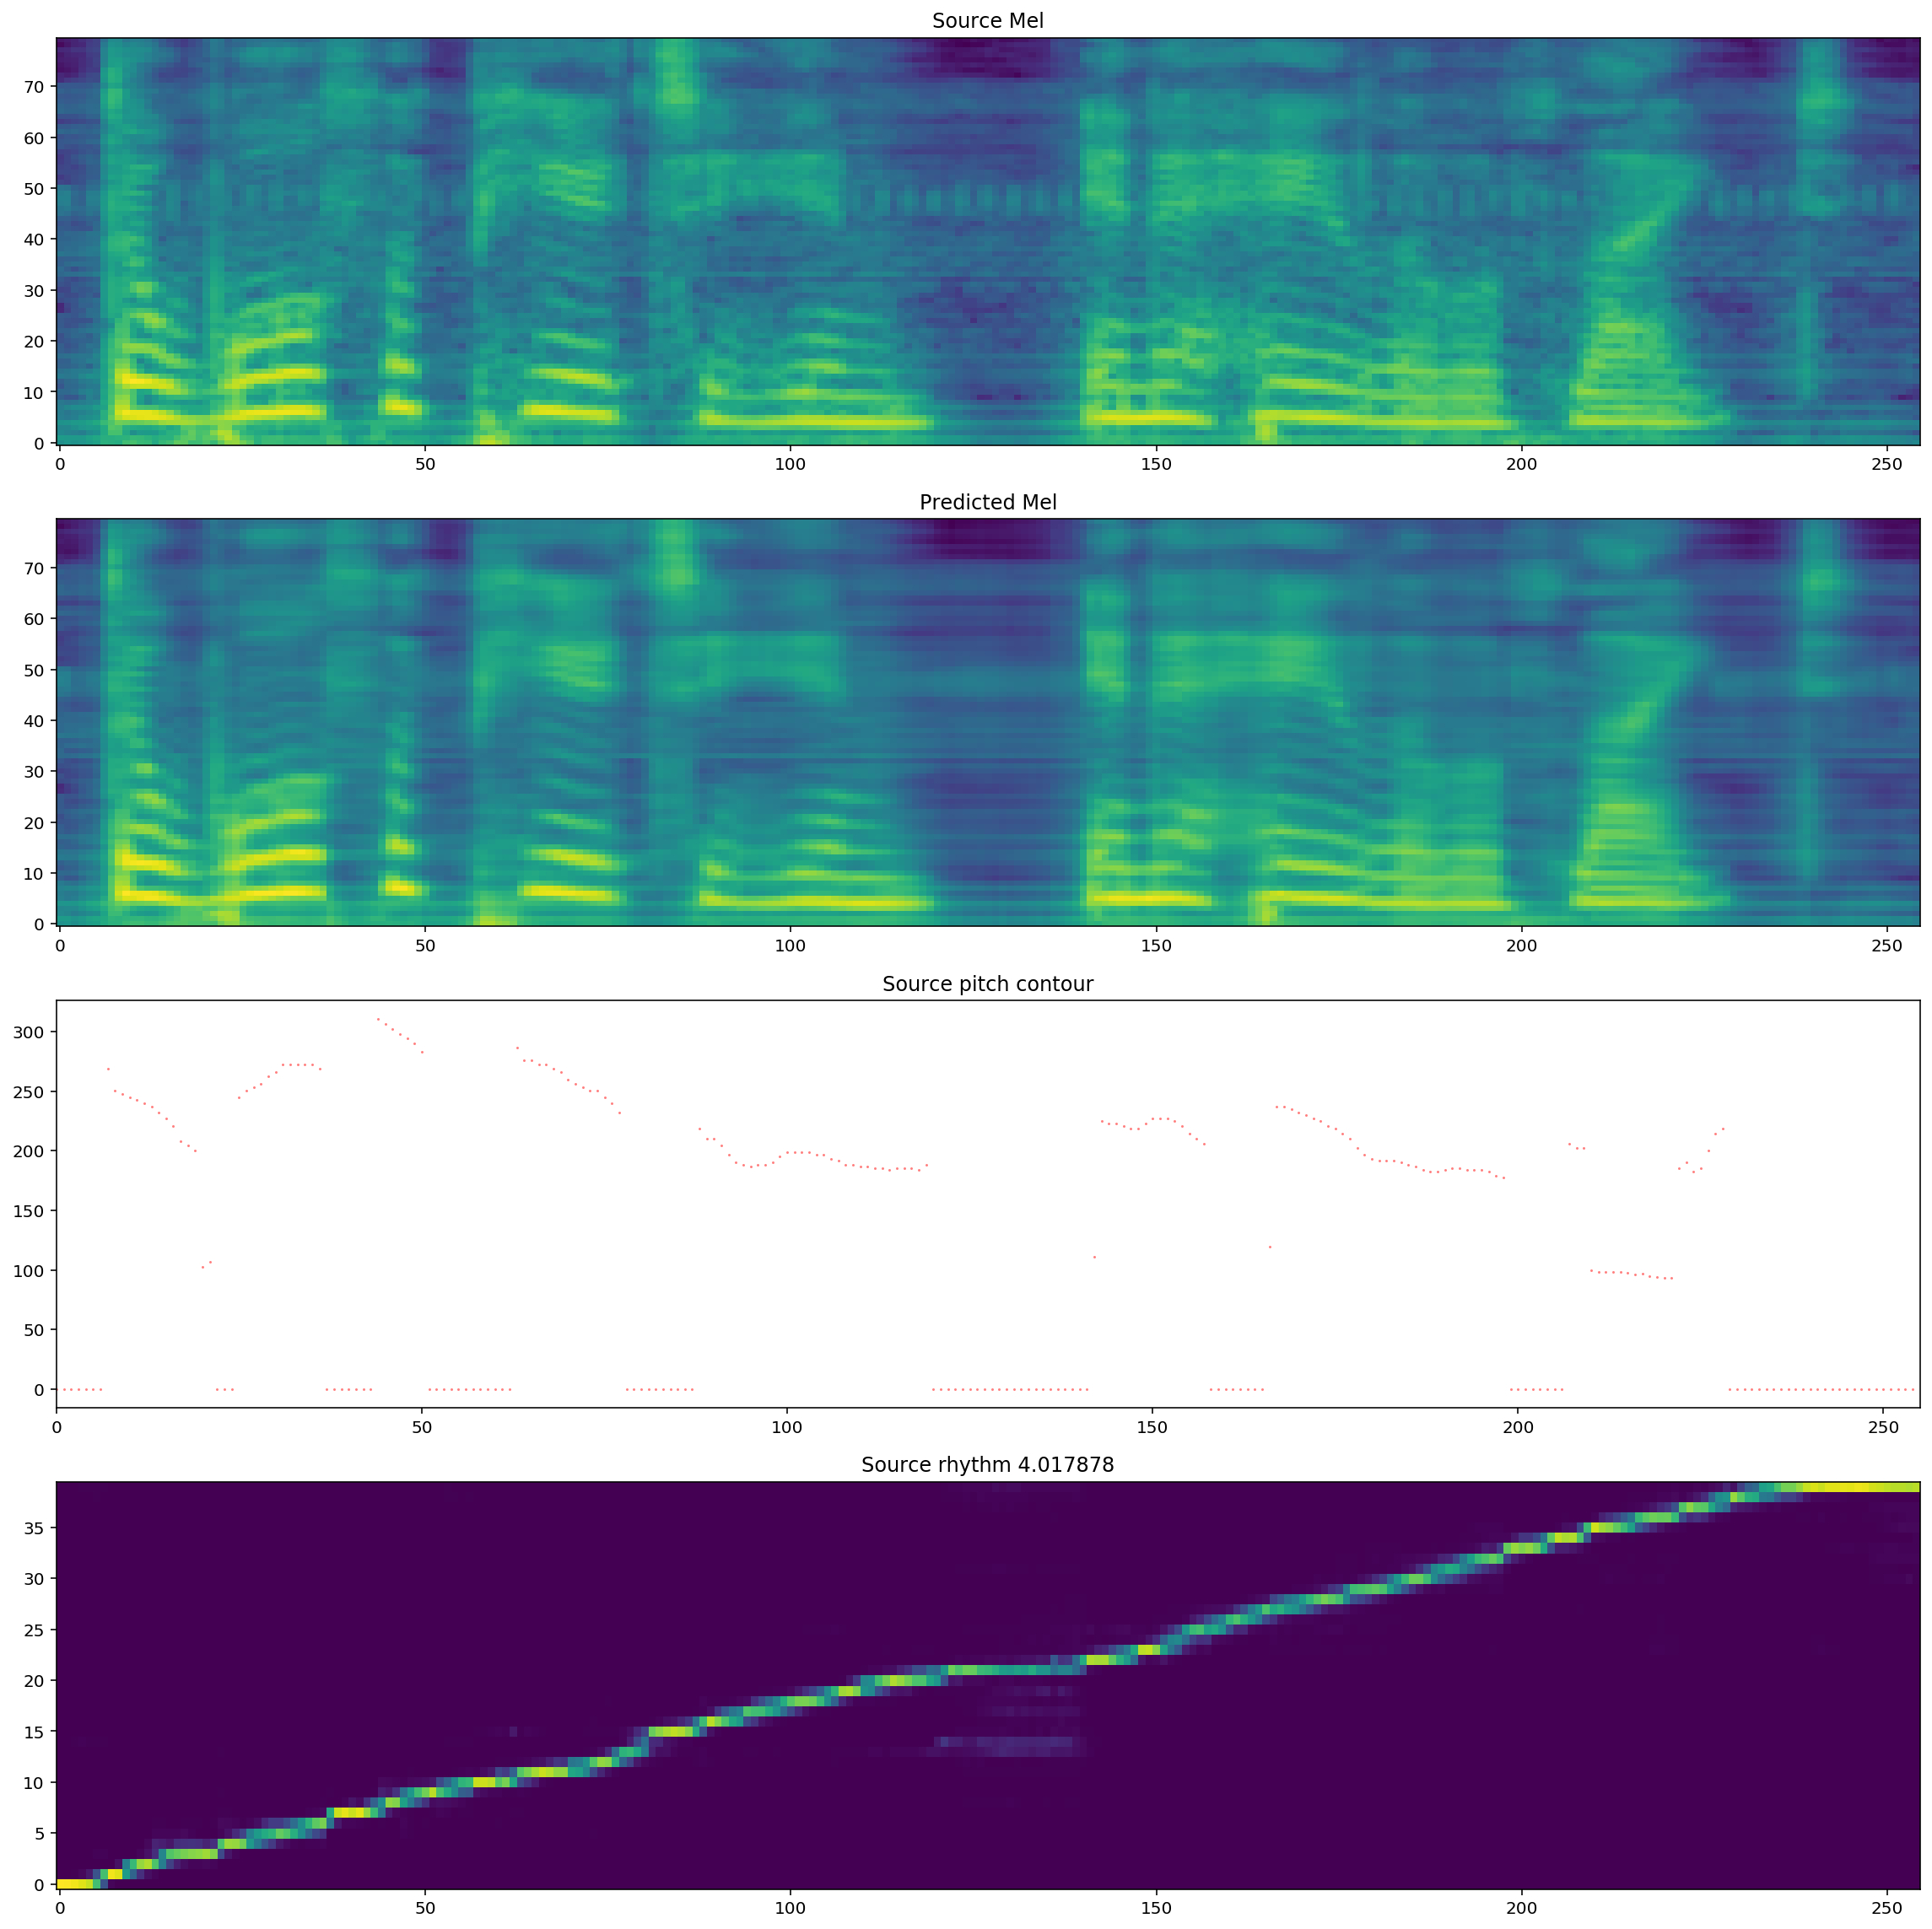

In [100]:
mcd_test = 1000.0
for i in range(90):
    with torch.no_grad():
        # get rhythm (alignment map) using tacotron 2
        x[5].value = i
        mel_outputsx, mel_outputs_postnetx, gate_outputsx, rhythmx, deco = mellotron.forward(x)
        rhythmx = rhythmx.permute(1, 0, 2)
        mcd_val = _calculate_mcd(x[2].data.cpu().numpy()[0],
                                 mel_outputs_postnetx.data.cpu().numpy()[0])
        #  plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
        #                mel_outputs_postnetx.data.cpu().numpy()[0],
        #                pitch_contour.data.cpu().numpy()[0, 0],
        #                rhythmx.data.cpu().numpy()[:, 0].T, mcd_val)           
        if mcd_val < mcd_test:
            mel_outputs, mel_outputs_postnet, gate_outputs, rhythm = mel_outputsx, mel_outputs_postnetx, gate_outputsx, rhythmx
            mcd_test = mcd_val

with torch.no_grad():
    audiox = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
ipd.Audio(audiox[0].data.cpu().numpy(), rate=hparams.sampling_rate)            

plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T, mcd_test)            

loss=2.8482041358947754
torch.Size([267, 1, 34])


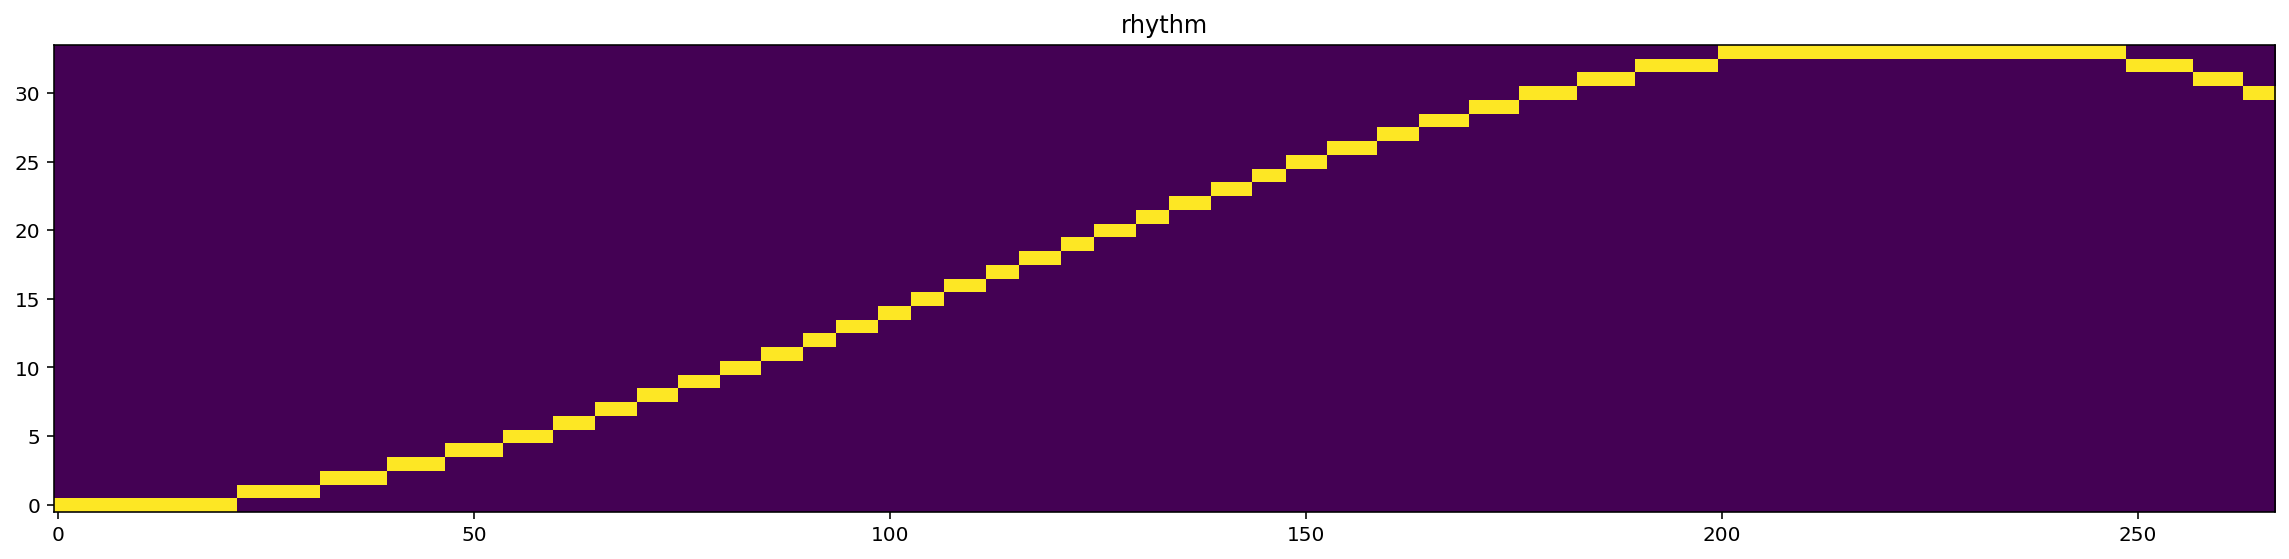

In [78]:
r2,_ = line_from_alignment(rhythm)
print(r2.shape)
plot_alignment(r2.data.cpu().numpy()[:, 0].T)
if torch.cuda.is_available():
    rhythm2 = r2.cuda()
else:
    rhythm2 = r2

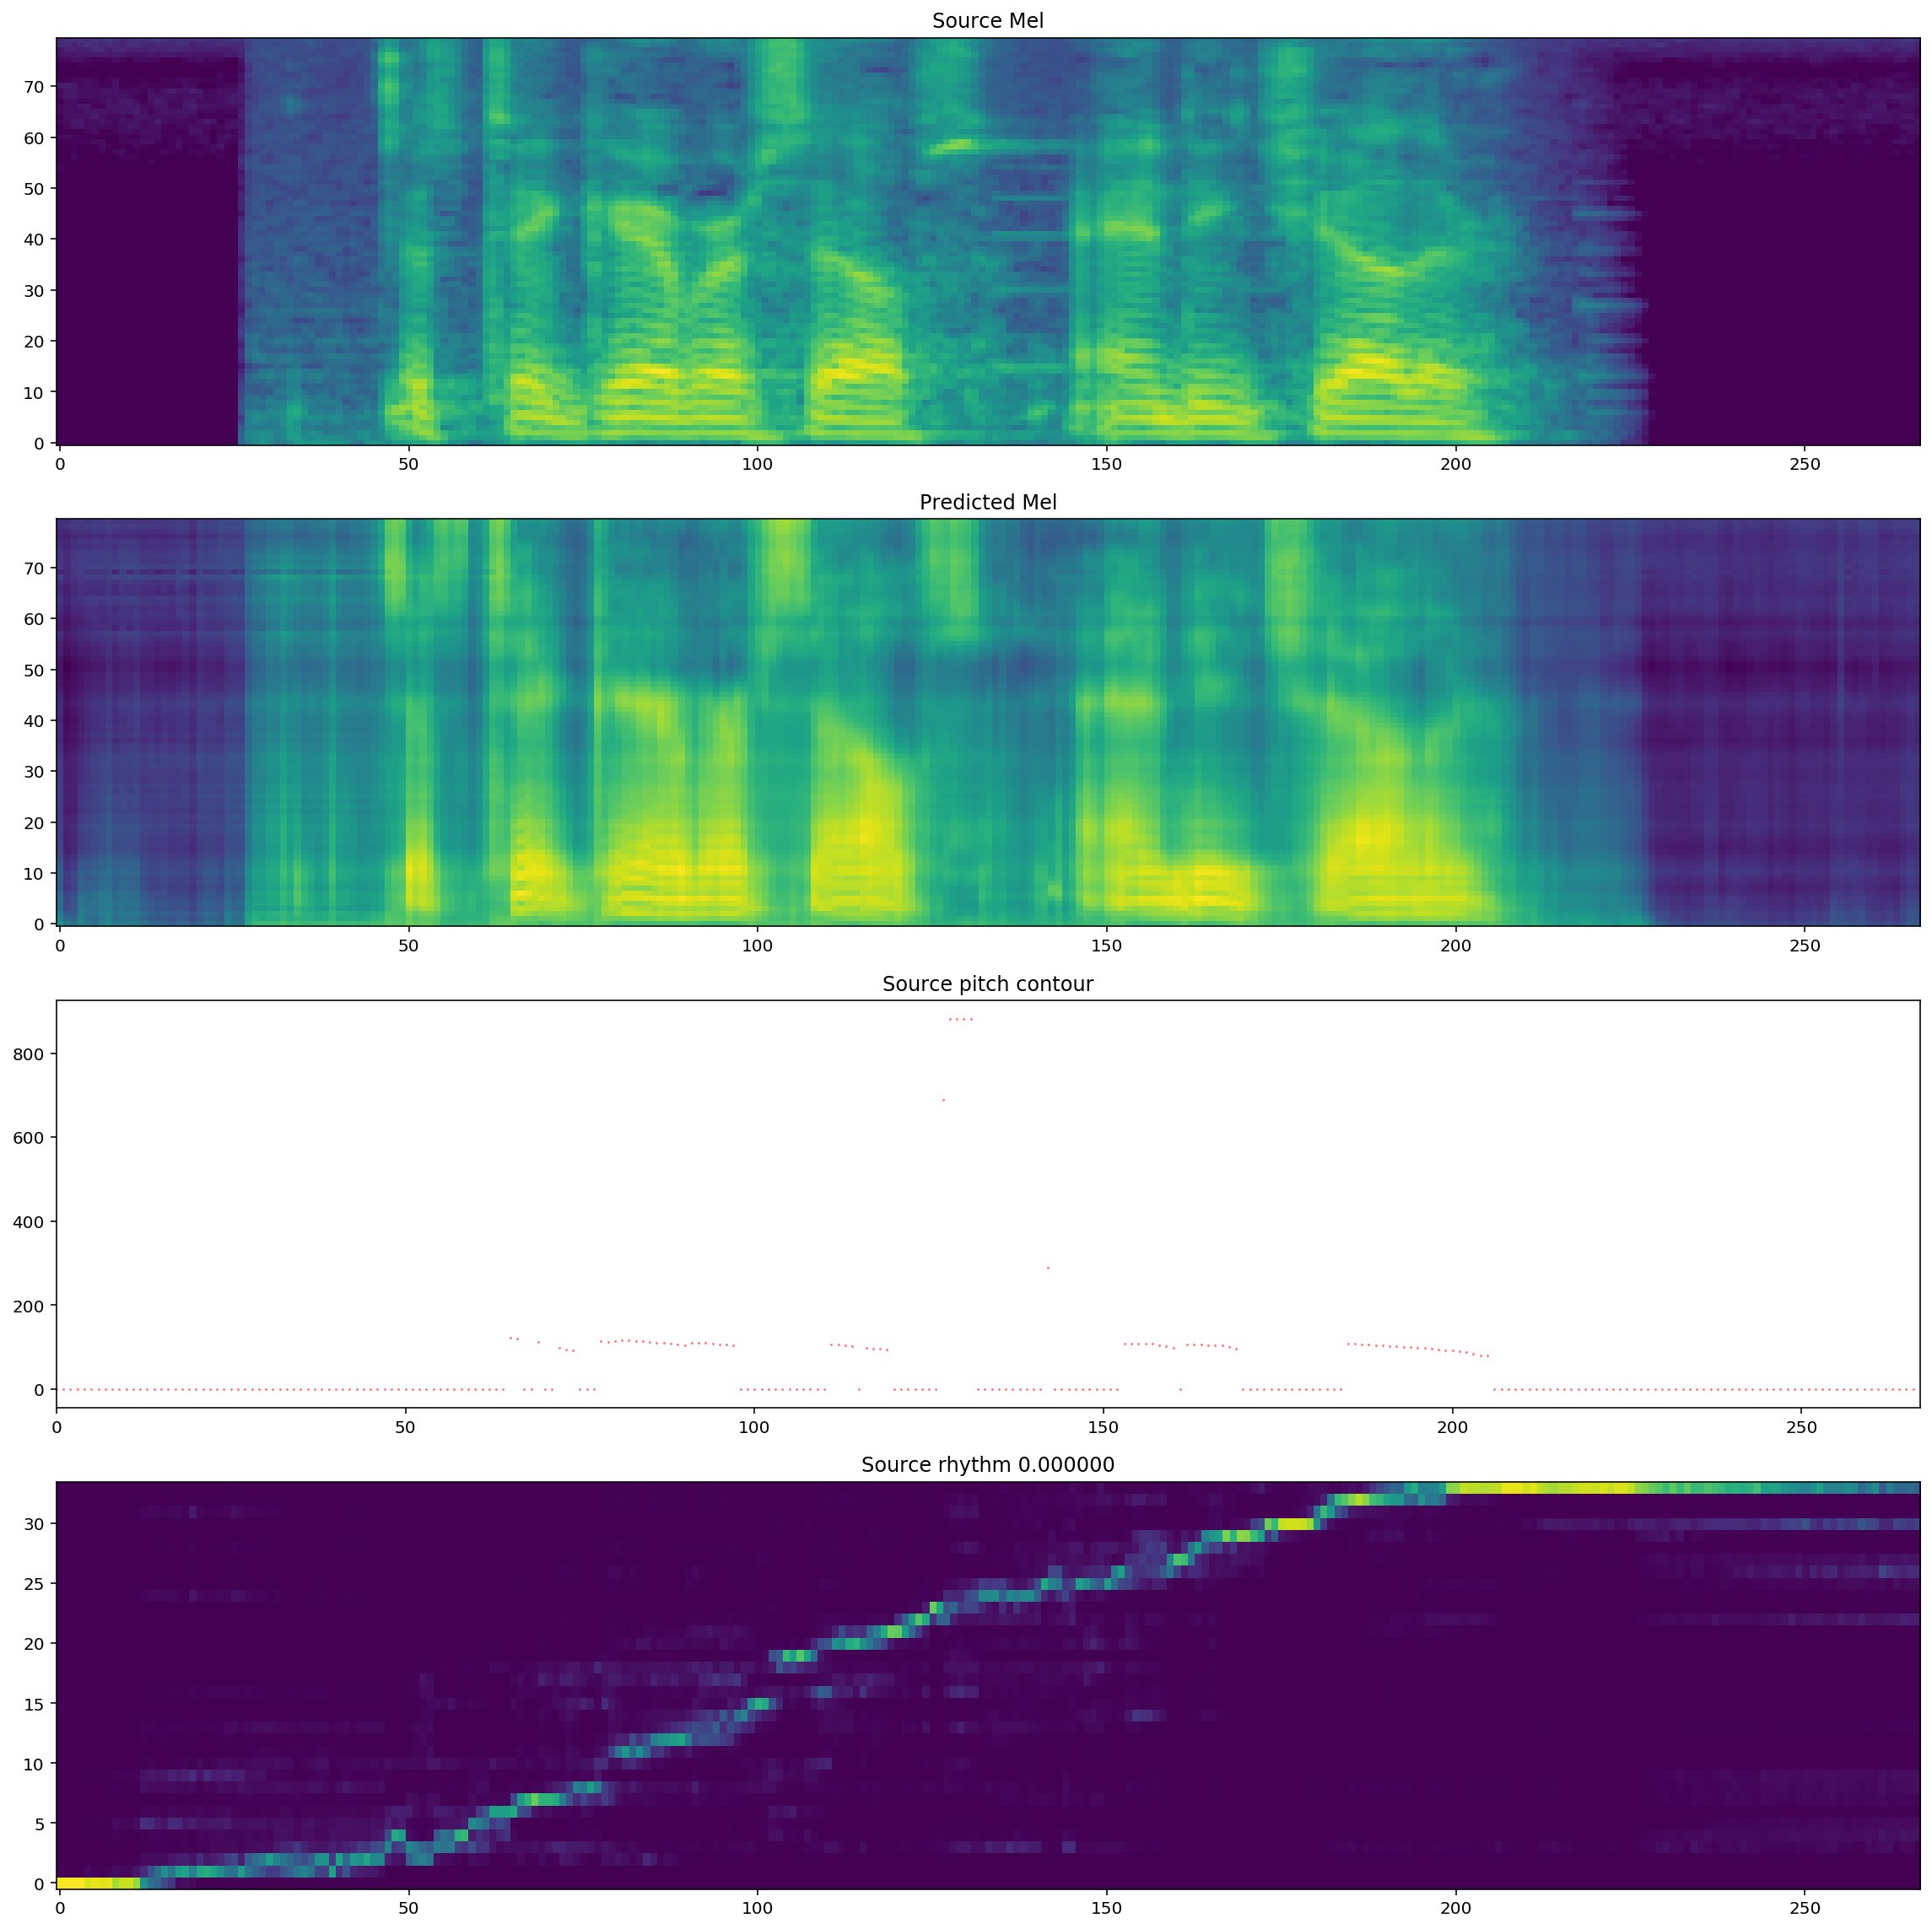

In [30]:

#with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2#
#    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm, deco = mellotron.forward(x)
#    rhythm = rhythm.permute(1, 0, 2)
plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)

In [68]:
mel2 = torch.zeros(mel.shape)
if torch.cuda.is_available():
    mel2=mel2.cuda()

In [102]:
mel2=mel
rhythm2=rhythm

In [108]:
speaker_id = next(female_speakers) if np.random.randint(2) else next(male_speakers)
# speaker_id=0
print(get_speaker_name(speaker_id))
speaker_id = torch.LongTensor([speaker_id])
if torch.cuda.is_available():
    speaker_id = speaker_id.cuda()

('kumarei', 'M')


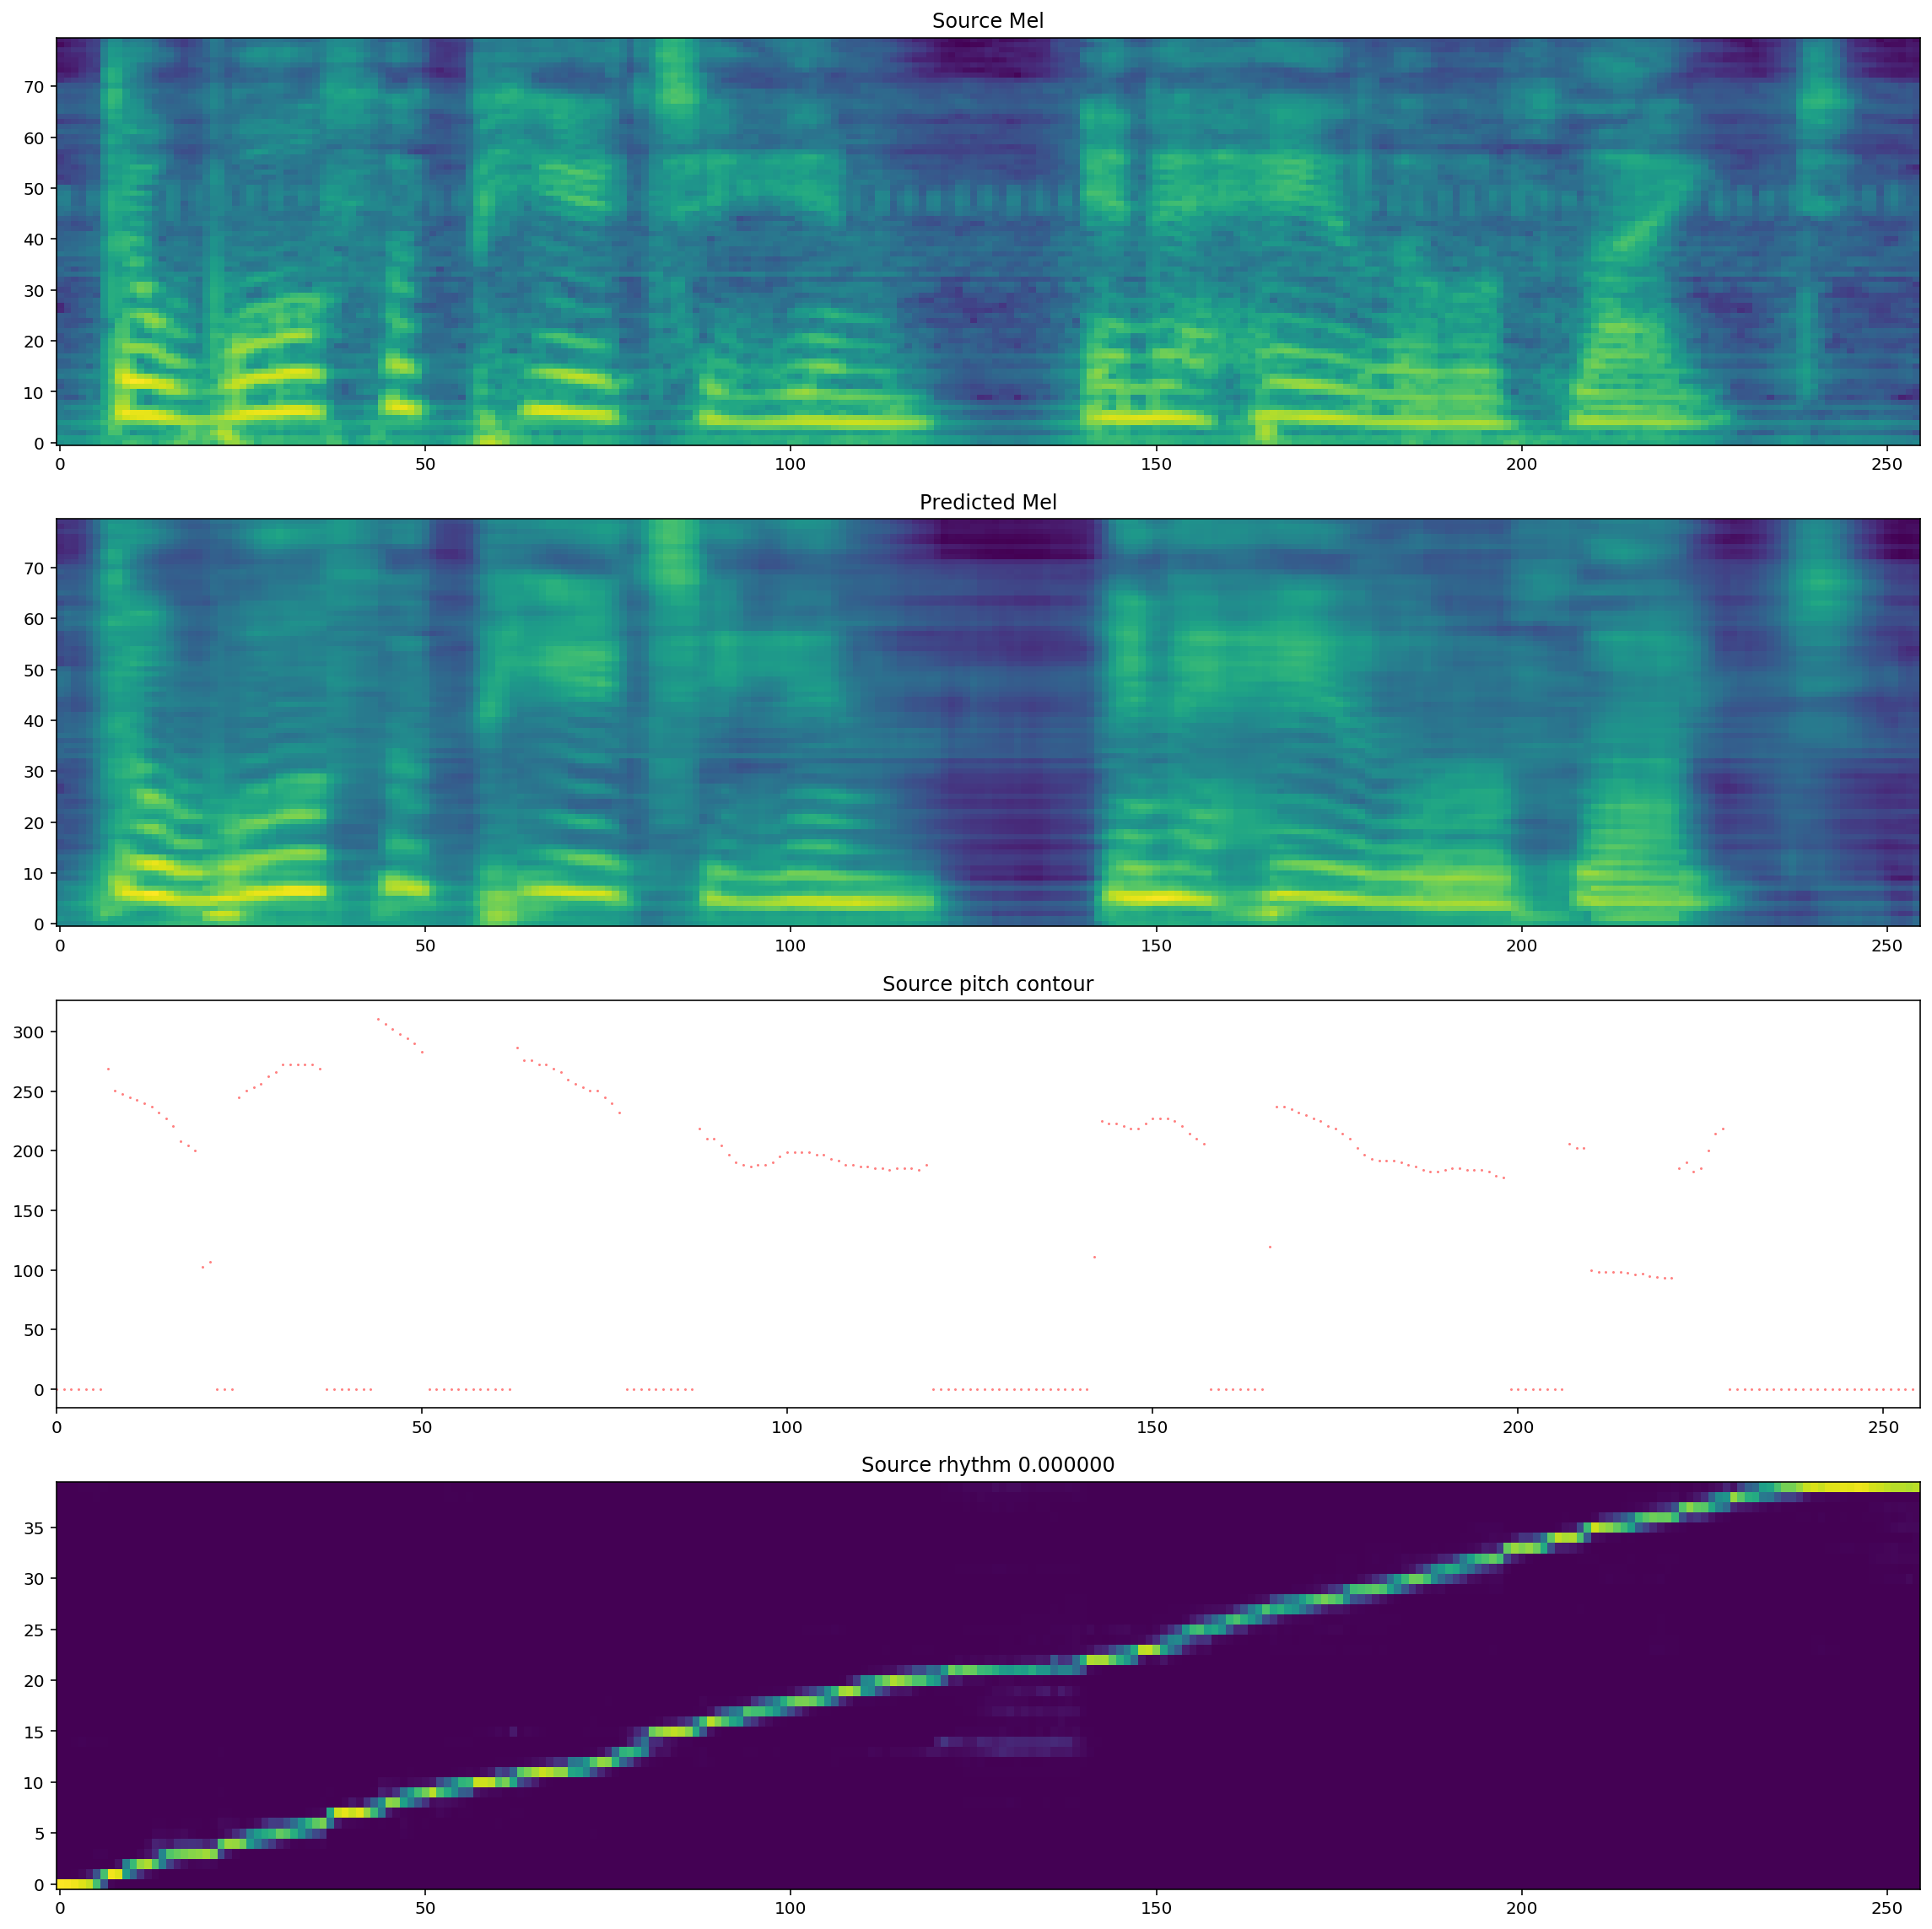

In [109]:
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs,alignments = mellotron.inference_noattention(
        (text_encoded, mel2, speaker_id, pitch_contour, rhythm2))

plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm2.data.cpu().numpy()[:, 0].T)


In [110]:
mcd_val = _calculate_mcd(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0])

print(mcd_val)

13.870485484914202


In [111]:

with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]


ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
print(sample_writes)
def do_save(b):
    global sample_writes
    audio_out = audio[0].data.cpu().numpy()
    audio_out = audio_out / np.max(np.abs(audio_out))
    filename = "mellotron_sample.{}.wav".format(sample_writes)
    write(filename, hparams.sampling_rate, audio_out)
    sample_writes += 1
    print(filename +" saved")

save_button = widgets.Button(description="save")
show_this(save_button)
save_button.on_click(do_save)


# Singing Voice from Music Score

In [ ]:
data = get_data_from_musicxml('data/haendel_hallelujah.musicxml', 132, convert_stress=True)
panning = {'Soprano': [-60, -30], 'Alto': [-40, -10], 'Tenor': [30, 60], 'Bass': [10, 40]}

In [ ]:
n_speakers_per_part = 4
frequency_scaling = 0.4
n_seconds = 90
audio_stereo = np.zeros((hparams.sampling_rate*n_seconds, 2), dtype=np.float32)
for i, (part, v) in enumerate(data.items()):
    rhythm = data[part]['rhythm'].cuda()
    pitch_contour = data[part]['pitch_contour'].cuda()
    text_encoded = data[part]['text_encoded'].cuda()
    
    for k in range(n_speakers_per_part):
        pan = np.random.randint(panning[part][0], panning[part][1])
        if any(x in part.lower() for x in ('soprano', 'alto', 'female')):
            speaker_id = torch.LongTensor([next(female_speakers)]).cuda()
        else:
            speaker_id = torch.LongTensor([next(male_speakers)]).cuda()
        print("{} MellotronID {} pan {}".format(part, speaker_id.item(), pan))

        with torch.no_grad():
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments_transfer = mellotron.inference_noattention(
                (text_encoded, mel, speaker_id, pitch_contour*frequency_scaling, rhythm))

            audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[0, 0]
            audio = audio.cpu().numpy()
            audio = panner(audio, pan)
            audio_stereo[:audio.shape[0]] += audio            
            write("{} {}.wav".format(part, speaker_id.item()), hparams.sampling_rate, audio)

In [ ]:
audio_stereo = audio_stereo / np.max(np.abs(audio_stereo))
write("audio_stereo.wav", hparams.sampling_rate, audio_stereo)
ipd.Audio([audio_stereo[:,0], audio_stereo[:,1]], rate=hparams.sampling_rate)